# Data exploration

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
df = pd.read_csv("/content/data.csv")
sns.set(style='whitegrid', color_codes=True)
np.random.seed(sum(map(ord, 'categorical')))
X=df.drop(['date','home_team','home_team_result','away_team','tournament'],axis=1)
y=df['home_team_result']
xcorr = X.corr(method='pearson')

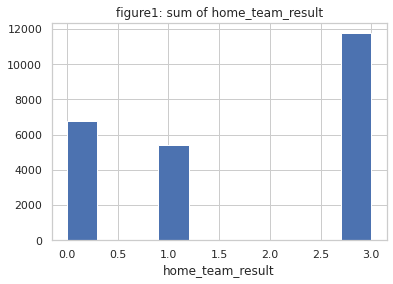

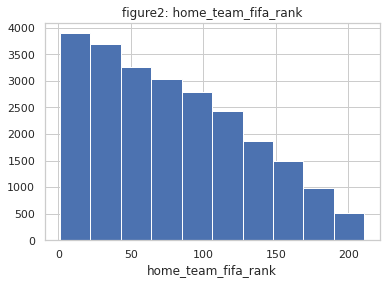

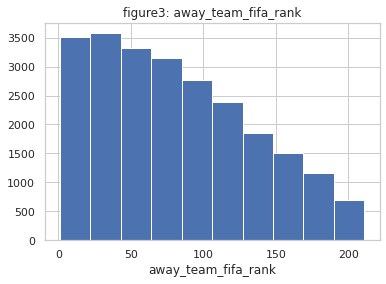

In [6]:
#Data overview
fig=plt.figure() 
ax = fig.add_subplot(1,1,1)
ax.hist(df['home_team_result']) 
plt.title('figure1: sum of home_team_result')
plt.xlabel('home_team_result')
plt.show()
fig=plt.figure() 
ax = fig.add_subplot(1,1,1)
ax.hist(df['home_team_fifa_rank'])
plt.title('figure2: home_team_fifa_rank')
plt.xlabel('home_team_fifa_rank')
plt.show()
fig=plt.figure() 
ax = fig.add_subplot(1,1,1)
ax.hist(df['away_team_fifa_rank']) 
plt.title('figure3: away_team_fifa_rank')
plt.xlabel('away_team_fifa_rank')
plt.show()

From figure 1, we can see that home_team have almost half of the winning. \\
Figure 2 and figure 3 shows that the home_team_rank are relatively higher(smaller) than away_team_rank. This can probably account for why home_team's win is more than loss.

Text(0.5, 1.0, 'figure4: Correlation heatmap of "X"')

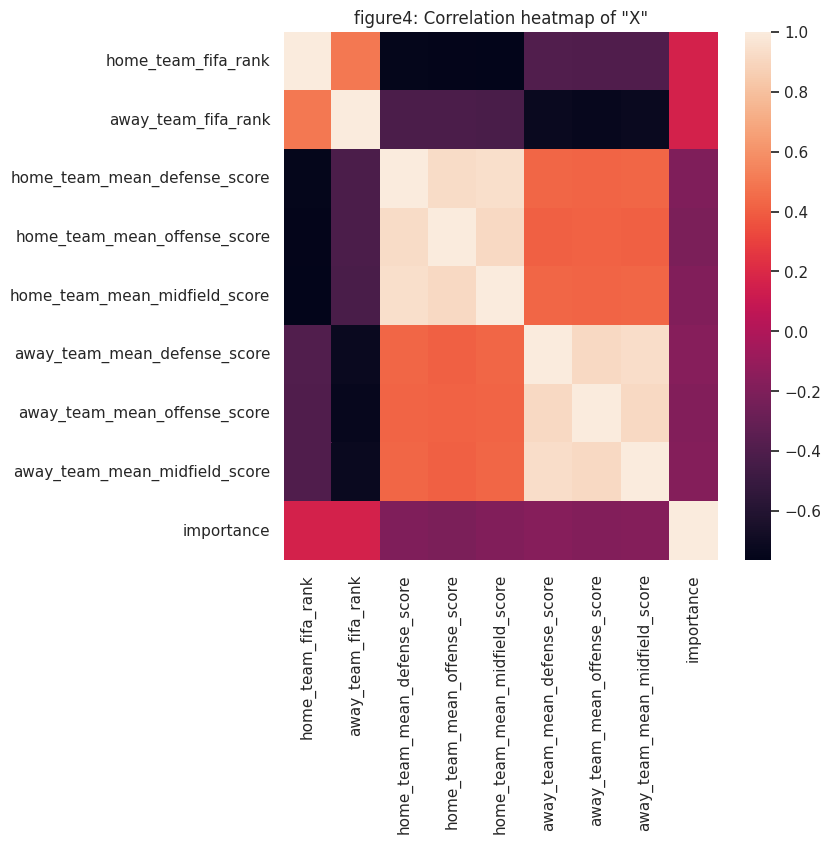

In [9]:
#correlation between different features
plt.figure(figsize=(7, 7),dpi=100)
sns.heatmap(data=xcorr)
plt.title('figure4: Correlation heatmap of "X"')

Figure 4 shows the Correlation heatmap of "X", it gives us some basic intuition of the data(e.g., if the rank is higher(smaller), the score should be bigger, thus those two features should have negative correlation).

Text(0.5, 1.0, 'figure5: Correlation heatmap between "X" and "Y"')

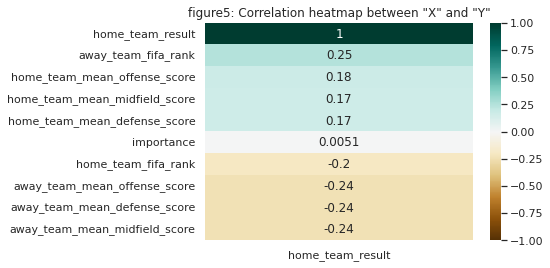

In [10]:
#correlation between feature and label
heatmap = sns.heatmap(df.corr()[['home_team_result']].sort_values(by='home_team_result', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.title('figure5: Correlation heatmap between "X" and "Y"')

Figure 5 shows the Correlation heatmap of "X" and "Y", it gives us some basic intuition of the relationship between data and label(e.g., if the home_rank is higher(smaller), home_team_result should be bigger(win)).

# Model walk-through

In [15]:
#Random Forest model walk_through
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, plot_confusion_matrix

For Random Forest, first we trained the basic model using RandomForestClassifier package. Then we wanted to find the best parameters from the following hyperparameters:

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
params_rf = {"max_depth": [20,30],
                "min_samples_split": [10,20],
                "max_leaf_nodes": [175,200],
                "min_samples_leaf": [5,10],
                "n_estimators": [250,300],
                 "max_features": ["sqrt"],
                }
rf = RandomForestClassifier(random_state=1)
#hyperparameter tuning
rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)
rf_cv.fit(X_train, y_train)
rf = rf_cv.best_estimator_
print('hyperparameter selection:', rf)
#final performance
print('train accuracy: ', rf.score(X_train, y_train))
print('test accuracy: ', rf.score(X_test, y_test))
cv_cross = cross_validate(rf, X,y, cv=kfold,) 
print('5-fold cross validation score: ', cv_cross['test_score'].mean())

hyperparameter selection: RandomForestClassifier(max_depth=30, max_features='sqrt', max_leaf_nodes=175,
                       min_samples_leaf=5, min_samples_split=10,
                       n_estimators=300, random_state=1)
train accuracy:  0.617056856187291
test accuracy:  0.5849529780564263
5-fold cross validation score:  0.5832948910160305


We tuned the object hyperparameters by doing grid search from sklearn package. We found that the best-performing model has an accuracy of 61.71\% on training data, and a 58.50\% accuracy on test data. \\
To further analyse our model performance, we use 5-fold cross validation error, confusion matrix and F1 score to evaluate the model. We also import \textbf{KFold} and \textbf{cross_validate} from sklearn to compute the mean 5-fold cross validation score, which is 58.33\%. The confusion matrix and F1 score are as follows:

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[0.55555556 0.00900901 0.71216931]


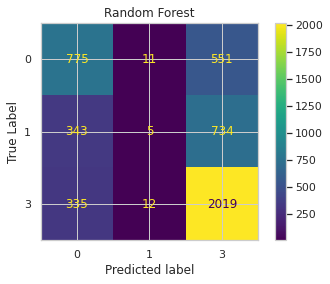

In [16]:
#confusion matrix & F1-score
cm = plot_confusion_matrix(rf, X_test, y_test)
plt.xlabel('Predicted label')
plt.ylabel('True Label')
plt.title('Random Forest')
print(f1_score(y_test, rf.predict(X_test),average=None))

From the confusion matrix and F1-score, we can observe that Random Forest model has the lowest F1-score on predicting both losing and winning cases, while has a relatively better prediction on draws than SVM and Neural Network. 

([0.2268687924725562,
  0.2741050431147113,
  0.3102787456445993,
  0.3322445779984322,
  0.34646739130434784,
  0.35824405539587145,
  0.36722657708100037,
  0.37601254246145804,
  0.379746835443038,
  0.38294314381270905],
 [0.42758620689655175,
  0.419226750261233,
  0.4150470219435737,
  0.41337513061650993,
  0.4148380355276907,
  0.4160919540229885,
  0.41379310344827586,
  0.412957157784744,
  0.41379310344827586,
  0.4150470219435737])

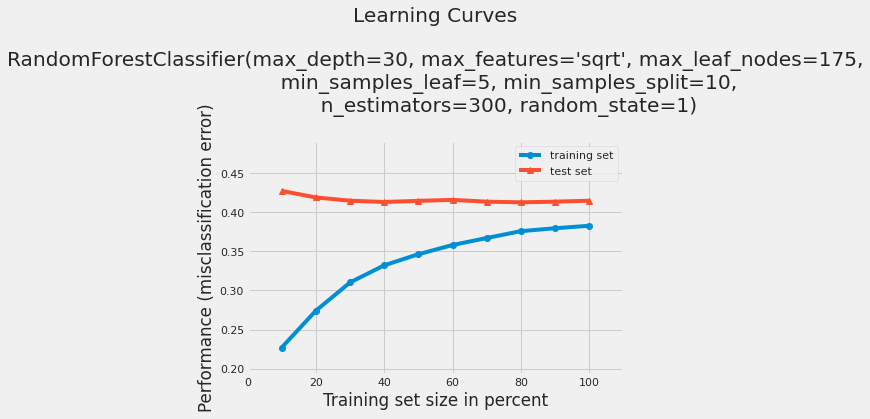

In [18]:
#train/test curves
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(X_train, y_train, X_test, y_test, rf)

From the tain/test learning curves we can observe that as the training set size increases, the method performance improves in terms of decrease in number of misclassification.